In [1]:
import time
import picamera
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
%config InlineBackend.figure_format = "svg"
import sys
sys.path.append("..")
import SHSlib  as sh
#import io

#%load_ext autoreload
#%autoreload 2

[[ 87 473]
 [331 391]
 [317 559]
 [131 355]
 [120 136]
 [336 210]]


<IPython.core.display.Javascript object>


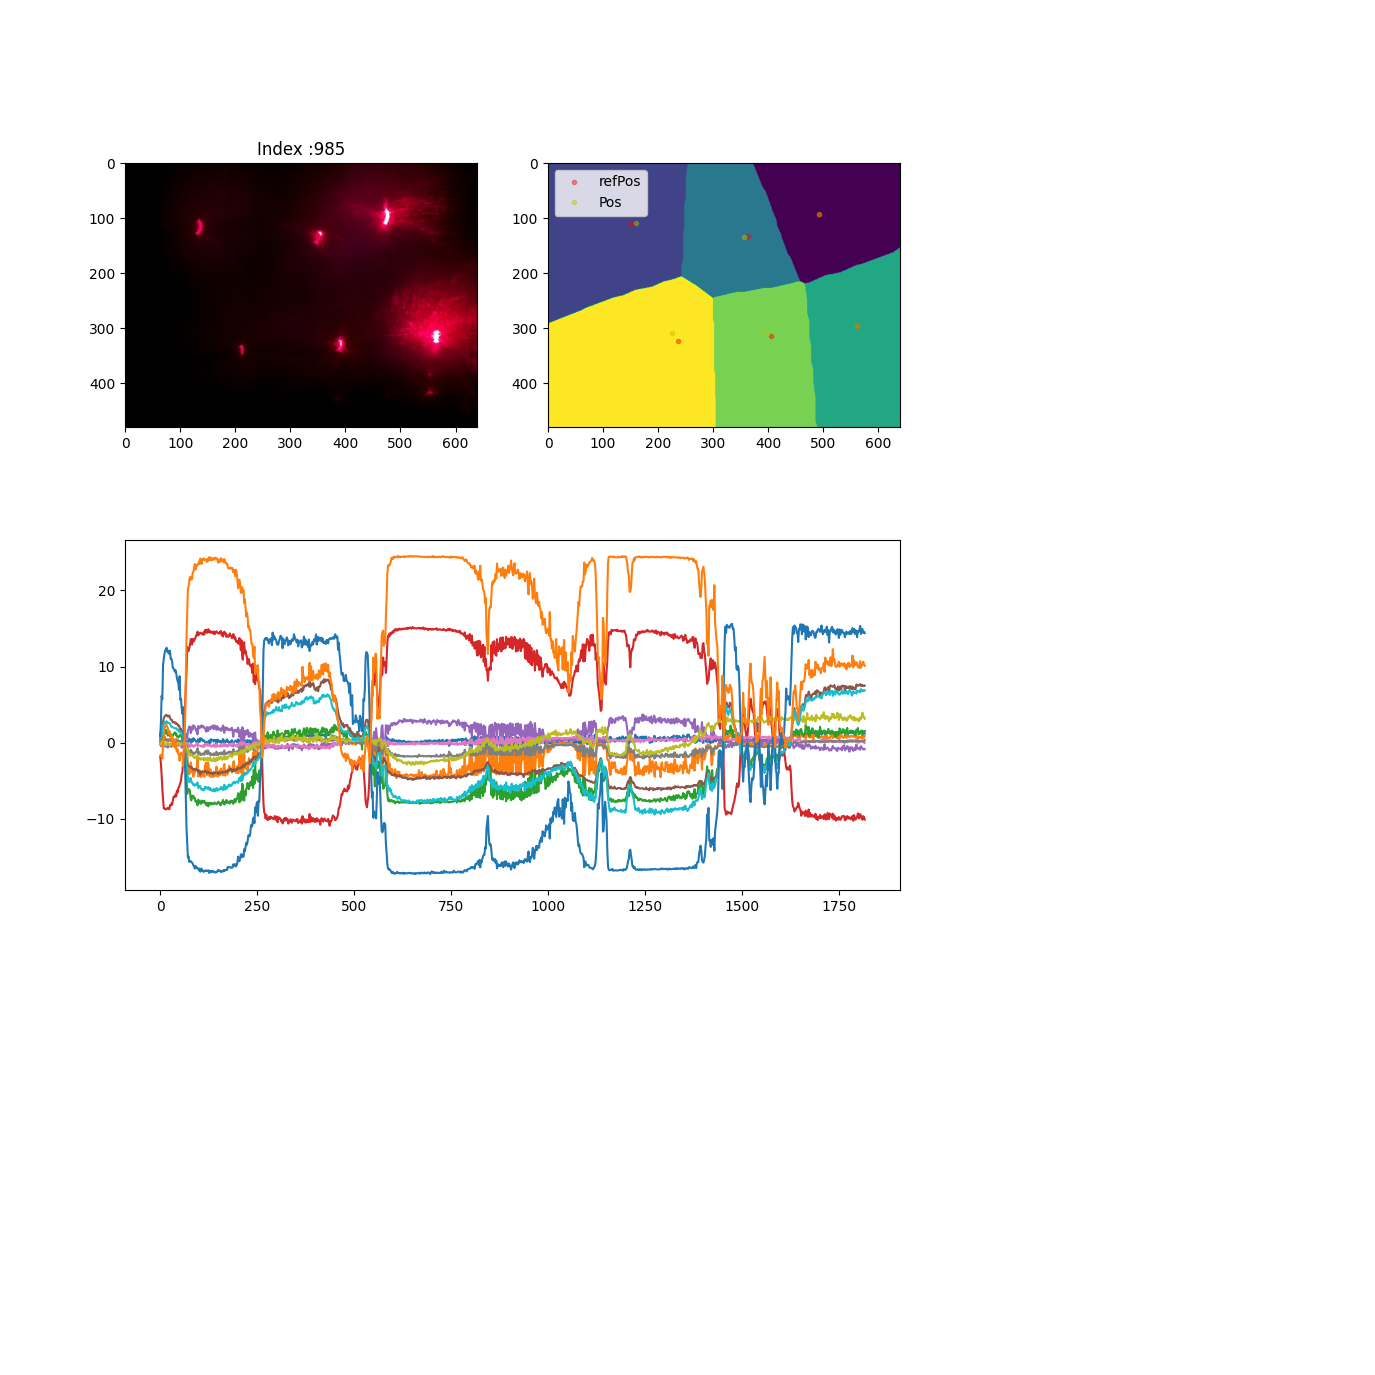

In [ ]:

indx = 0 

resolution = (640,480)
#resolution = (1280,720)
#resolution = (1640,1232)
#resolution =(2016, 1520)

min_distance = 80

indx_end = 1000

with picamera.PiCamera(
    # Camera Setup 
    sensor_mode= 4,  
    resolution= resolution,
    framerate= 1
) as camera:
    #setup Ploting
    
    
    
    # addition camera setup
    time.sleep(1)  # let the camera warm up and set gain/white balance
    camera.exposure_mode = 'off'
    camera.awb_mode = 'off'
    camera.awb_gains = 2.5

    camera.shutter_speed = int(6e6)
    camera.iso = 50
    output = np.zeros((*reversed(resolution),3), dtype=np.uint8)
    
    # get ref image
    for i in range(5):
        camera.capture(output,'rgb',use_video_port=True)
        
    PIL_ref_img = Image.fromarray(output,'RGB')
    ref_img = np.mean(PIL_ref_img,2) 
    
    # precess pef image
    ref_lables = sh.analyse.getSeperation(ref_img,min_distance=min_distance)
    ref_center = sh.analyse.getMomentum(ref_lables,ref_img, algorythm="C") 

    
    fig = plt.figure(figsize=(10,10))
    axSensor = fig.add_subplot(221)
    axPeakArea = fig.add_subplot(222)
    axPeakPosOverTime = fig.add_subplot(212)

    imageSensorImg =  axSensor.imshow(PIL_ref_img)
    
    imagePeakArea = axPeakArea.imshow(ref_lables)
    linePeakPoints1 = axPeakArea.plot(ref_center[0],ref_center[1],"r.",label='refPos',linewidth=0.1,alpha=0.4)
    linePeakPoints2 = axPeakArea.plot(ref_center[0],ref_center[1],"y.",label='Pos',linewidth=0.1,alpha=0.4)
    axPeakArea.legend()
    
    ShiftOverTimeX = np.zeros((len(ref_center[0]),indx_end))
    ShiftOverTimeY = np.zeros((len(ref_center[0]),indx_end))
    
    timeOfCapture = np.zeros(indx_end)
    timeOfCapture[0] = 0

    
    linePeakPosOverXTime = []
    linePeakPosOverYTime = []
    for i in range(len(ref_center[0])):
        linePeakPosOverXTime += [axPeakPosOverTime.plot(ref_center[0][i])]
        linePeakPosOverYTime += [axPeakPosOverTime.plot(ref_center[1][i])]
    fig.canvas.draw()
    plt.show()
    
        
    
    t0 = time.time_ns()
    
    for i in range(0,indx_end):
    
        # continuous capture 
        camera.capture(output,'rgb',use_video_port=True)
        timeOfCapture[i] = (time.time_ns() - t0) /1e9
        
        Sensor_img = Image.fromarray(output,'RGB')
        img = np.mean(Sensor_img,2)
        
        center = sh.analyse.getMomentum(ref_lables, img, algorythm="C") 
        partners = sh.analyse.getPartner(center, ref_center)
        
        ShiftOverTimeX[:,i] = partners[0]
        ShiftOverTimeY[:,i] = partners[1]

        if True: #i%0 == 0:
            # Set data for Ploting
            imageSensorImg.set_data(Sensor_img) 

            #imagePeakArea.set_data(img)

            linePeakPoints2[0].set_xdata(center[0])
            linePeakPoints2[0].set_ydata(center[1])
            axSensor.set_title("Index :" + str(indx))


            #if i> 40:
            #    pltStart = i-40
                
            for j in range(len(ShiftOverTimeX[:,i])):
                linePeakPosOverYTime[j][0].set_ydata(ShiftOverTimeX[j,0:i+1])
                linePeakPosOverYTime[j][0].set_xdata(timeOfCapture[0:i+1])

                linePeakPosOverXTime[j][0].set_ydata(ShiftOverTimeY[j,0:i+1])
                linePeakPosOverXTime[j][0].set_xdata(timeOfCapture[0:i+1])
                axPeakPosOverTime.relim() 
                axPeakPosOverTime.autoscale_view(True,True,True) 

            fig.canvas.draw()
        indx += 1 
